In [36]:
import random
from functools import cache
from tqdm import trange

import tensorflow as tf
import numpy as np

def num_chars(d):
    set_ = set()
    for s in d:
        for l in s:
            set_.add(l)
    return len(set_), set_

@cache
def get_dataset(path):
    print("loading dataset")
    with open(path) as file:
        dataset = [s.strip() for s in file.readlines()]
    return dataset, *num_chars(dataset)

In [46]:
class Environment:
    def __init__(self, path, max_lives = 10):
        self.dataset, self.letters, self.letters_list = get_dataset(path)
        self.max_len = max([len(s) for s in self.dataset])
        self.only_letters_list = list(self.letters_list)
        self.letters_list = list(self.letters_list) + ["_"] # used for placeholder for guessed letters
        self.lives = 0
        self.max_lives = max_lives
        self.current_word = self.dataset[random.randrange(0, len(self.dataset))]
        self.current_word_remaining = self.current_word
        self.already_chosen_letters = []

    def act(self, letter:str):
        if letter in self.already_chosen_letters:
            raise Exception("already chosen")
        if letter == "_":
            raise Exception("what? '_'?")


        self.already_chosen_letters.append(letter)
        if letter not in self.current_word:
            self.lives += 1
            if self.lives == self.max_lives:
                self.reset()
                return -1, 1
            return -1, 0

        self.current_word_remaining = self.current_word_remaining.replace(letter, "_")
        if len(set(list(self.current_word_remaining))) == 1:
            return 1, 1

        return 1, 0

    def reset(self):
        self.lives = 0
        self.current_word = self.dataset[random.randrange(0, len(self.dataset))]
        self.current_word_remaining = self.current_word
        self.already_chosen_letters = []


class Agent:
    def __init__(self, env:Environment):
        self.discount = 0.999
        self.clip_eps = 0.2
        self.actor = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation=tf.nn.selu),
            tf.keras.layers.Dense(64, activation=tf.nn.selu),
            tf.keras.layers.Dense(len(env.only_letters_list), activation="softmax")
        ])

        self.critic = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation=tf.nn.selu),
            tf.keras.layers.Dense(64, activation=tf.nn.selu),
            tf.keras.layers.Dense(1, activation="linear")
        ])

        self.optimizer_actor = tf.optimizers.legacy.Adam(4e-4)
        self.optimizer_critic = tf.optimizers.legacy.Adam(4e-4)

    def mask(self, env:Environment):
        mask = np.ones(len(env.only_letters_list))
        for l in env.already_chosen_letters:
            mask[self.only_letter_to_int(env, l)] = 0
        return mask

    def state(self, env:Environment):
        w = np.zeros((env.max_len, len(env.letters_list) + 1))
        for i in range(env.max_len):
            if i < len(env.current_word):
                w[i, self.letter_to_int(env, env.current_word[i])] = 1
            else:
                w[i, 0] = 1

        l = np.zeros(len(env.letters_list) + 1)
        for el in env.already_chosen_letters:
            l[self.letter_to_int(env, el)] = 1

        d = np.zeros(env.max_lives)
        d[env.lives] = 1

        return np.concatenate((
            w.reshape((-1)),
            l.reshape((-1)),
            d.reshape((-1))
        ))

    def letter_to_int(self, env: Environment, letter):
        return env.letters_list.index(letter) + 1

    def only_letter_to_int(self, env: Environment, letter):
        return env.letters_list.index(letter)

    def int_to_only_letter(self, env: Environment, letter_idx):
        return env.only_letters_list[letter_idx]

    def learn(self, states, new_states, samples, rewards, dones, masks):
        actions = tf.one_hot(samples, depth=masks.shape[-1])
        initial_probs = None

        val = self.critic(states)
        new_val = self.critic(new_states)

        reward_to_go = tf.stop_gradient(rewards + self.discount * new_val * (1-dones))
        td_error = reward_to_go - val

        for _ in range(10):
            with tf.GradientTape() as a_tape:
                probs = self.actor(states)
                probs = probs * masks
                probs = probs / tf.reduce_sum(probs, axis=-1, keepdims=True)

                selected_actions_probs = tf.reduce_sum(probs * actions, axis=-1, keepdims=True)

                if initial_probs is None:
                    initial_probs = tf.convert_to_tensor(tf.stop_gradient(selected_actions_probs))
                importance_sampling_ratio = selected_actions_probs / (initial_probs + 1e-8)


                loss_actor = tf.minimum(
                    td_error * importance_sampling_ratio,
                    td_error * tf.clip_by_value(importance_sampling_ratio, 1 - self.clip_eps, 1 + self.clip_eps)
                )

                loss_actor = tf.reduce_mean(-loss_actor)

            grad_actor = a_tape.gradient(loss_actor, self.actor.trainable_weights)
            self.optimizer_actor.apply_gradients(zip(grad_actor, self.actor.trainable_weights))

        for _ in range(3):
            with tf.GradientTape() as c_tape:
                val = self.critic(states)
                new_val = tf.stop_gradient(self.critic(new_states))

                reward_to_go = tf.stop_gradient(rewards + self.discount * new_val * (1-dones))

                loss_critic = tf.losses.mean_squared_error(val, reward_to_go)[:, None]

                loss_critic = tf.reduce_mean(loss_critic)

            grad_critic = c_tape.gradient(loss_critic, self.critic.trainable_weights)
            self.optimizer_critic.apply_gradients(zip(grad_critic, self.critic.trainable_weights))

In [47]:
envs = [Environment("dataset.txt") for _ in range(256)]

In [48]:
agent = Agent(envs[0])

In [49]:
rewards_history = []
for e in trange(10000):
    states = []
    masks = []
    for env in envs:
        states.append(agent.state(env))
        masks.append(agent.mask(env))
    states = np.array(states)
    masks = np.array(masks)

    probs = agent.actor(states)
    probs = probs * masks
    probs = probs * tf.linalg.norm(probs, ord=1, axis=-1)[0]

    samples = tf.random.categorical(tf.math.log(probs), 1)[:, 0]

    rewards = []
    dones = []
    for sample, env in zip(samples, envs):
        r,d = env.act(agent.int_to_only_letter(env, sample))
        rewards.append(r)
        dones.append(d)


    rewards = np.array(rewards)
    dones = np.array(dones)

    new_states = []
    for env in envs:
        new_states.append(agent.state(env))
    new_states = np.array(new_states)


    agent.learn(states, new_states, samples, rewards, dones, masks)
    rewards_history.append(np.mean(rewards))




 56%|█████▌    | 5562/10000 [23:18<18:35,  3.98it/s]


IndexError: list index out of range

In [40]:
import matplotlib.pyplot as plt

In [44]:
rewards_history = np.reshape(rewards_history, (-1, 50)).mean(axis=-1)

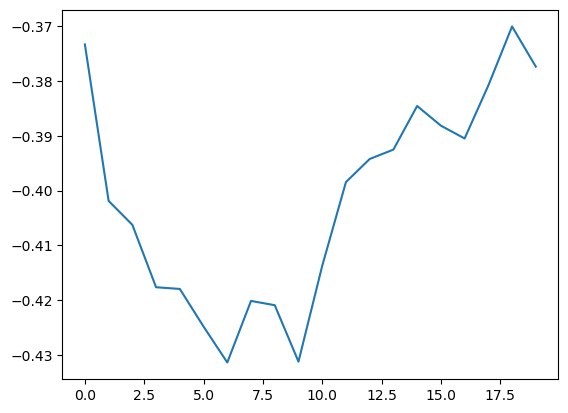

In [45]:
plt.plot(rewards_history)